# Практическая работа №5. Атака с ограниченной памятью (PGD)

Выполнил Сердюков Матвей, ББМО-01-23

## Цель задания

Изучить одну из наиболее мощных атак на модели ИИ — атаку Projected Gradient Descent (PGD).
Научиться использовать PGD для создания противоречивых примеров и оценить её влияние на
обученные модели.

## Задачи

1. Загрузить ранее обученную модель на датасете MNIST.
2. Изучить теоретические основы атаки PGD.
3. Реализовать атаку PGD с помощью фреймворка Foolbox.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных
данных.

## Загрузка обученной модели и данных MNIST

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('../mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.9736 - loss: 0.0915
Test accuracy on clean images: 0.9768000245094299


## Реализация атаки PGD с использованием Foolbox

I0000 00:00:1734691565.533824    2938 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-20 13:46:05.533889: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


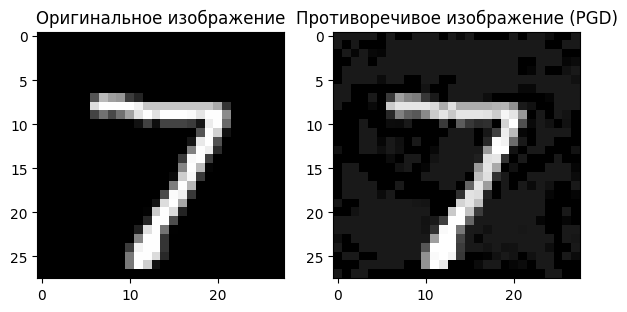

In [13]:
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор изображения для атаки
image = tf.convert_to_tensor(test_images[0], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label = tf.convert_to_tensor(label, dtype=tf.int64)

# Создание атаки PGD
attack = fb.attacks.LinfPGD()

# Выполнение атаки
adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.1)  

# Вывод оригинального и противоречивого изображения
plt.figure(figsize=(7, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (PGD)")
plt.imshow(adversarial_image[0].numpy(), cmap="gray")
plt.show()

## Оценка модели на противоречивых примерах

In [14]:
# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []

for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    adv_image, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(adv_image)

adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (PGD): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.0408 - loss: 8.1764
Accuracy on adversarial examples (PGD): 0.051500000059604645


## Вывод

Точность модели снизилась с 97,7% до 5,2%, что говорит об её уязвимостя к атакам типа PGD. Это означает, что небольшие и целонаправленные изменения входных данных способны ввести модель в заблуждение.